In [1]:
import json
import optuna
import lightfm
import numpy as np
import pandas as pd
import scipy.stats as ss
import tensorboardX as tb
import lightfm.data as ld
import matplotlib.pyplot as pl
import lightfm.evaluation as lv

np.random.seed(31337)

C:\Users\asus\PycharmProjects\recsys\venv\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
DATA_DIR = "../logs/"

In [3]:
data = pd.concat([
    pd.read_json(DATA_DIR + "the_biggest_data.json", lines=True),
    pd.read_json(DATA_DIR + "big_data.json", lines=True),
    pd.read_json(DATA_DIR + "input_hw.json", lines=True),
    pd.read_json(DATA_DIR + "input_2.json", lines=True),
    pd.read_json(DATA_DIR + "input_3.json", lines=True),
    pd.read_json(DATA_DIR + "input_4.json", lines=True),
    pd.read_json(DATA_DIR + "input_5.json", lines=True),
    pd.read_json(DATA_DIR + "input_6.json", lines=True)
]).drop_duplicates(subset=["user", "track"])
data

,message,timestamp,user,track,time,latency,recommendation,experiments
0,next,2023-04-07 20:41:54.968,1660,7772,1.00,0.001027,4988.0,{'CHECK_HW': 'T1'}
1,next,2023-04-07 20:41:54.976,1660,4988,0.04,0.000541,7295.0,{'CHECK_HW': 'T1'}
2,next,2023-04-07 20:41:54.984,1660,7295,0.00,0.000491,3711.0,{'CHECK_HW': 'T1'}
3,next,2023-04-07 20:41:54.992,1660,3711,1.00,0.001059,6707.0,{'CHECK_HW': 'T1'}
4,next,2023-04-07 20:41:55.001,1660,6707,0.89,0.001045,3711.0,{'CHECK_HW': 'T1'}
...,...,...,...,...,...,...,...,...
815244,next,2022-06-13 11:39:37.527,2753,34339,0.00,0.000949,19557.0,"{'AA': 'C', 'COLLABORATIVE': 'T1'}"
815246,next,2022-06-13 11:39:37.544,2753,17167,0.00,0.000912,2802.0,"{'AA': 'C', 'COLLABORATIVE': 'T1'}"
815247,next,2022-06-13 11:39:37.552,2753,2802,0.00,0.000852,16105.0,"{'AA': 'C', 'COLLABORATIVE': 'T1'}"
815251,next,2022-06-13 11:39:37.612,4013,4360,0.00,0.001012,2189.0,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"


In [4]:
positives = data[data["time"] > 0.8].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7
positives

,message,timestamp,user,track,time,latency,recommendation,experiments,test
0,next,2023-04-07 20:41:54.968,1660,7772,1.00,0.001027,4988.0,{'CHECK_HW': 'T1'},True
3,next,2023-04-07 20:41:54.992,1660,3711,1.00,0.001059,6707.0,{'CHECK_HW': 'T1'},True
4,next,2023-04-07 20:41:55.001,1660,6707,0.89,0.001045,3711.0,{'CHECK_HW': 'T1'},False
8,next,2023-04-07 20:41:55.044,8183,3590,1.00,0.000547,13908.0,{'CHECK_HW': 'C'},False
11,next,2023-04-07 20:41:55.067,8183,505,0.82,0.000588,199.0,{'CHECK_HW': 'C'},False
...,...,...,...,...,...,...,...,...,...
815149,next,2022-06-13 11:39:36.396,2368,443,1.00,0.000787,1508.0,"{'AA': 'T1', 'COLLABORATIVE': 'C'}",False
815190,next,2022-06-13 11:39:36.892,5317,10685,1.00,0.001123,52.0,"{'AA': 'T1', 'COLLABORATIVE': 'C'}",False
815219,next,2022-06-13 11:39:37.228,3358,99,0.91,0.000835,221.0,"{'AA': 'C', 'COLLABORATIVE': 'T1'}",False
815230,next,2022-06-13 11:39:37.354,8213,12490,0.94,0.000924,4359.0,"{'AA': 'C', 'COLLABORATIVE': 'T1'}",True


In [5]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)
user_counts

user
0        4
1       18
2       54
3       14
4       28
        ..
9995    59
9996    33
9997    50
9998    29
9999    14
Length: 9997, dtype: int64

In [6]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)
track_counts

track
0         1
1         1
2         2
3         1
7        31
         ..
49990     4
49993     1
49994     3
49996     2
49999     1
Length: 29454, dtype: int64

## Train LightFM

In [7]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(212419, 87544)

In [8]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [9]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [10]:
def fit_model(
        epochs=1,
        at=10,
        loss="warp",
        no_components=30,
        learning_rate=0.01,
        max_sampled=10,
        user_alpha=0.0,
        item_alpha=0.0,
        threads=30,
        verbose=False,
        patience=3,
        epsilon=1e-6,
):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []

    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at,
                                         num_threads=threads)

        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")

        precisions_at.append(np.mean(precision_at))

        if epoch > patience and all(
                [precisions_at[-j] - precisions_at[-patience - 1] < epsilon for j in range(1, patience + 1)]):
            if verbose:
                print("Early stopping!")
            break

    else:
        if verbose:
            print("No early stopping happened: increase epochs maybe?")

    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001, 0.001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001, 0.001])

    model_fit_model, precisions_at_fit_model = fit_model(
        epochs=5,
        at=10,
        loss=loss,
        no_components=no_components,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    return precisions_at_fit_model[-1]

In [11]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
best_params = study.best_params

[I 2023-04-09 10:58:19,016] A new study created in memory with name: no-name-cad6c7db-8cb6-41ac-9406-9d054b972dde
[I 2023-04-09 10:59:08,895] Trial 0 finished with value: 0.03317967429757118 and parameters: {'loss': 'warp', 'no_components': 50, 'learning_rate': 0.001, 'max_sampled': 100, 'user_alpha': 0.001, 'item_alpha': 0.0001}. Best is trial 0 with value: 0.03317967429757118.
[I 2023-04-09 10:59:50,116] Trial 1 finished with value: 0.0064215268939733505 and parameters: {'loss': 'bpr', 'no_components': 30, 'learning_rate': 0.0001, 'max_sampled': 50, 'user_alpha': 0.0001, 'item_alpha': 0.001}. Best is trial 0 with value: 0.03317967429757118.
[I 2023-04-09 11:00:32,053] Trial 2 finished with value: 0.030135078355669975 and parameters: {'loss': 'bpr', 'no_components': 30, 'learning_rate': 0.001, 'max_sampled': 10, 'user_alpha': 0.0001, 'item_alpha': 0.001}. Best is trial 0 with value: 0.03317967429757118.
[I 2023-04-09 11:00:58,707] Trial 3 finished with value: 0.028966553509235382 and 

In [12]:
model_given, precisions_at_given = fit_model(
    epochs=400,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"],
    learning_rate=best_params["learning_rate"],
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.03292238712310791 +/- 0.0015461373352749534
1:	0.033243998885154724 +/- 0.0015612212029399567
2:	0.03369425609707832 +/- 0.0015665696021231463
3:	0.034294597804546356 +/- 0.0015886700590651431
4:	0.035934820771217346 +/- 0.001633555304351707
5:	0.036781735718250275 +/- 0.0016680006401479344
6:	0.0372212715446949 +/- 0.0016815334977538202
7:	0.038336191326379776 +/- 0.001716799698593033
8:	0.03890437260270119 +/- 0.0017425907974275036
9:	0.039922814816236496 +/- 0.0017762343193863845
10:	0.04162735864520073 +/- 0.001833160682637262
11:	0.042613640427589417 +/- 0.0018585766541606903
12:	0.04373927786946297 +/- 0.0018969445727180486
13:	0.04447899013757706 +/- 0.0019127222973884417
14:	0.04586191847920418 +/- 0.0019617791519098513
15:	0.04673027619719505 +/- 0.001993705343760382
16:	0.047898802906274796 +/- 0.0020176856708588424
17:	0.04796312376856804 +/- 0.002016180474413287
18:	0.048852916806936264 +/- 0.0020384660002100664
19:	0.0494103766977787 +/- 0.0020439716474398026
20:	0.04

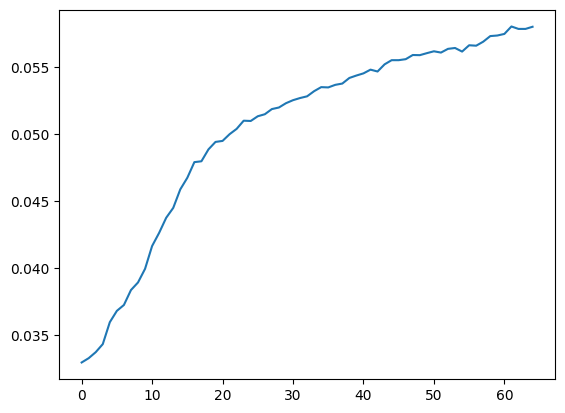

In [13]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at_given)), precisions_at_given)

pass

## Save track embeddings

In [14]:
biases, embeddings = model_given.get_item_representations()

In [15]:
model_given.item_biases *= 0.0

In [16]:
TRACK_DATA_DIR = "../botify/data/"
track_meta = pd.read_json(TRACK_DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [17]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [18]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)),
                     tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [19]:
k = 50

with open(TRACK_DATA_DIR + f"recommendations_by_artist_neighbours_{k}.json", "w") as rf:
    artists_tracks = dict()

    for artist in dataset_tracks.artist:
        if artist not in artists_tracks.items():
            artists_tracks[artist] = list(dataset_tracks[dataset_tracks["artist"] == artist].track)

    for artist in artists_tracks:
        recommendations = []
        neighbours = []
        embeddings_of_artist = list(
            embeddings[int(dataset_tracks[dataset_tracks["track"] == int(j)].dataset_index)] for j in
            artists_tracks[artist])

        for i in range(len(dataset_tracks)):
            if dataset_tracks.iloc[i].artist != artist:
                embedding = embeddings[int(dataset_tracks.iloc[i].dataset_index)]
                dist = sum(-np.dot(embeddings_of_artist, embedding))
                neighbours.append(dist)

        neighbours = np.argsort(neighbours)

        for neighbour in neighbours:
            if len(recommendations) == k:
                break

            recommended_track = dataset_tracks[dataset_tracks["dataset_index"] == neighbour].iloc[0]
            recommendation = int(recommended_track["track"])
            recommendations.append(recommendation)

        track_with_recommendations = dict()
        track_with_recommendations["artist"] = artist
        track_with_recommendations["recommendations"] = recommendations

        rf.write(json.dumps(track_with_recommendations) + "\n")

In [22]:
with open(TRACK_DATA_DIR + f"personal_top_{k}.json", "w") as rf:
    for user in range(max(data.user)):
        user_data = data[(data["user"] == user) & (data["time"] > 0.5)].copy()

        track_popularity = (
            user_data
            .groupby("track")["time"]
            .sum()
            .to_frame()
            .sort_values("time", ascending=False)
            .reset_index()
        )

        recommendations = track_popularity["track"].head(k).tolist()

        track_with_recommendations = dict()
        track_with_recommendations["user"] = user
        track_with_recommendations["tracks"] = recommendations

        rf.write(json.dumps(track_with_recommendations) + "\n")

In [23]:
with open(TRACK_DATA_DIR + f"controlled_personal_top_{k}.json", "w") as rf:
    control = pd.read_json(DATA_DIR + "control.json", lines=True)
    personal_top = pd.read_json(TRACK_DATA_DIR + f"personal_top_{k}.json", lines=True)
    i = 0

    for tracks in personal_top.tracks:
        control_tracks = []
        for track in tracks:
            if not control[(control["user"] == i) & (control["time"] < 0.5)].copy().empty:
                lst = control[(control["user"] == i) & (control["time"] < 0.5)].copy().track.array

                if track in lst:
                    continue

            control_tracks += [track]

        controlled_tracks_with_recommendations = dict()
        controlled_tracks_with_recommendations["user"] = i
        controlled_tracks_with_recommendations["tracks"] = control_tracks
        rf.write(json.dumps(controlled_tracks_with_recommendations) + "\n")
        i += 1